# network3.ipynb based on network3.py

#### from http://neuralnetworksanddeeplearning.com/chap6.html

## Libraries

### Standard Library

In [1]:
import cPickle 
import gzip

### Third-party libraries

In [139]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.nnet import conv
from theano.tensor.nnet import softmax
from theano.tensor import shared_randomstreams
from theano.tensor.signal import pool


### Activation functions for neurons

In [4]:
def linear(z): return z
def ReLU(z): return T.maximum(0.0, z)
from theano.tensor.nnet import sigmoid
from theano.tensor import tanh

## Constants

In [5]:
GPU = False
if GPU:
    print "Trying to run under a GPU.  If this is not desired, then modify "+\
        "network3.py\nto set the GPU flag to False."
    try: theano.config.device = 'gpu'
    except: pass # it's already set
    theano.config.floatX = 'float32'
else:
    print "Running with a CPU.  If this is not desired, then the modify "+\
        "network3.py to set\nthe GPU flag to True."

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


## Load the MNIST data

In [74]:
#download data
#!wget http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz
import matplotlib
import numpy 
import matplotlib.pyplot as plt


def load_data_shared(filename="/content/mnist.pkl.gz"):
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = cPickle.load(f)
    f.close()
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.rcParams['image.cmap'] = 'gray'
    for i in range(9):
      plt.subplot(1,10,i+1)
      plt.imshow(test_data[0][i].reshape(28,28))
      plt.axis('off')
      plt.title(str(test_data[1][i]))

    plt.show()
    def shared(data):
        """Place the data into shared variables.  This allows Theano to copy
        the data to the GPU, if one is available.

        """
        shared_x = theano.shared(
            np.asarray(data[0], dtype=theano.config.floatX), borrow=True)
        shared_y = theano.shared(
            np.asarray(data[1], dtype=theano.config.floatX), borrow=True)
        return shared_x, T.cast(shared_y, "int32")
    return [shared(training_data), shared(validation_data), shared(test_data)]

## Main class used to construct and train networks

In [136]:
class Network(object):

    def __init__(self, layers, mini_batch_size):
        """Takes a list of `layers`, describing the network architecture, and
        a value for the `mini_batch_size` to be used during training
        by stochastic gradient descent.

        """
        self.layers = layers
        self.mini_batch_size = mini_batch_size
        self.params = [param for layer in self.layers for param in layer.params]
        self.x = T.matrix("x")
        self.y = T.ivector("y")
        init_layer = self.layers[0]
        init_layer.set_inpt(self.x, self.x, self.mini_batch_size)
        for j in xrange(1, len(self.layers)):
            prev_layer, layer  = self.layers[j-1], self.layers[j]
            layer.set_inpt(
                prev_layer.output, prev_layer.output_dropout, self.mini_batch_size)
        self.output = self.layers[-1].output
        self.output_dropout = self.layers[-1].output_dropout
        
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            validation_data, test_data, lmbda=0.0):
        """Train the network using mini-batch stochastic gradient descent."""
        training_x, training_y = training_data
        validation_x, validation_y = validation_data
        test_x, test_y = test_data

        # compute number of minibatches for training, validation and testing
        num_training_batches = size(training_data)/mini_batch_size
        num_validation_batches = size(validation_data)/mini_batch_size
        num_test_batches = size(test_data)/mini_batch_size

        # define the (regularized) cost function, symbolic gradients, and updates
        l2_norm_squared = sum([(layer.w**2).sum() for layer in self.layers])
        cost = self.layers[-1].cost(self)+\
               0.5*lmbda*l2_norm_squared/num_training_batches
        grads = T.grad(cost, self.params)
        updates = [(param, param-eta*grad)
                   for param, grad in zip(self.params, grads)]

        # define functions to train a mini-batch, and to compute the
        # accuracy in validation and test mini-batches.
        i = T.lscalar() # mini-batch index
        train_mb = theano.function(
            [i], cost, updates=updates,
            givens={
                self.x:
                training_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                training_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        validate_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                validation_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                validation_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        test_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                test_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        self.test_mb_predictions = theano.function(
            [i], self.layers[-1].y_out,
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        # Do the actual training
        best_validation_accuracy = 0.0
        for epoch in xrange(epochs):
            for minibatch_index in xrange(num_training_batches):
                iteration = num_training_batches*epoch+minibatch_index
                if iteration % 1000 == 0:
                    print("Training mini-batch number {0}".format(iteration))
                cost_ij = train_mb(minibatch_index)
                if (iteration+1) % num_training_batches == 0:
                    validation_accuracy = np.mean(
                        [validate_mb_accuracy(j) for j in xrange(num_validation_batches)])
                    print("Epoch {0}: validation accuracy {1:.2%}".format(
                        epoch, validation_accuracy))
                    if validation_accuracy >= best_validation_accuracy:
                        print("This is the best validation accuracy to date.")
                        best_validation_accuracy = validation_accuracy
                        best_iteration = iteration
                        if test_data:
                            test_accuracy = np.mean([test_mb_accuracy(j) for j in xrange(num_test_batches)])
                            print('The corresponding test accuracy is {0:.2%}'.format(test_accuracy))
        print("Finished training network.")
        print("Best validation accuracy of {0:.2%} obtained at iteration {1}".format(
            best_validation_accuracy, best_iteration))
        print("Corresponding test accuracy of {0:.2%}".format(test_accuracy))

## Define layer types

In [142]:
class ConvPoolLayer(object):
    """Used to create a combination of a convolutional and a max-pooling
    layer.  A more sophisticated implementation would separate the
    two, but for our purposes we'll always use them together, and it
    simplifies the code, so it makes sense to combine them.

    """

    def __init__(self, filter_shape, image_shape, poolsize=(2, 2),
                 activation_fn=sigmoid):
        """`filter_shape` is a tuple of length 4, whose entries are the number
        of filters, the number of input feature maps, the filter height, and the
        filter width.

        `image_shape` is a tuple of length 4, whose entries are the
        mini-batch size, the number of input feature maps, the image
        height, and the image width.

        `poolsize` is a tuple of length 2, whose entries are the y and
        x pooling sizes.

        """
        self.filter_shape = filter_shape
        self.image_shape = image_shape
        self.poolsize = poolsize
        self.activation_fn=activation_fn
        # initialize weights and biases
        n_out = (filter_shape[0]*np.prod(filter_shape[2:])/np.prod(poolsize))
        self.w = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=np.sqrt(1.0/n_out), size=filter_shape),
                dtype=theano.config.floatX),
            borrow=True)
        self.b = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=1.0, size=(filter_shape[0],)),
                dtype=theano.config.floatX),
            borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape(self.image_shape)
        conv_out = conv.conv2d(
            input=self.inpt, filters=self.w, filter_shape=self.filter_shape,
            image_shape=self.image_shape)
        pooled_out = pool.pool_2d(
            input=conv_out, ws=self.poolsize, ignore_border=True)
        self.output = self.activation_fn(
            pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        self.output_dropout = self.output # no dropout in the convolutional layers

In [9]:
class FullyConnectedLayer(object):

    def __init__(self, n_in, n_out, activation_fn=sigmoid, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.activation_fn = activation_fn
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0.0, scale=np.sqrt(1.0/n_out), size=(n_in, n_out)),
                dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.asarray(np.random.normal(loc=0.0, scale=1.0, size=(n_out,)),
                       dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = self.activation_fn(
            (1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = self.activation_fn(
            T.dot(self.inpt_dropout, self.w) + self.b)

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))


In [10]:
class SoftmaxLayer(object):

    def __init__(self, n_in, n_out, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.zeros((n_in, n_out), dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.zeros((n_out,), dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = softmax((1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = softmax(T.dot(self.inpt_dropout, self.w) + self.b)

    def cost(self, net):
        "Return the log-likelihood cost."
        return -T.mean(T.log(self.output_dropout)[T.arange(net.y.shape[0]), net.y])

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))

## Miscellanea

In [11]:
def size(data):
    "Return the size of the dataset `data`."
    return data[0].get_value(borrow=True).shape[0]

def dropout_layer(layer, p_dropout):
    srng = shared_randomstreams.RandomStreams(
        np.random.RandomState(0).randint(999999))
    mask = srng.binomial(n=1, p=1-p_dropout, size=layer.shape)
    return layer*T.cast(mask, theano.config.floatX)




## Load Data 

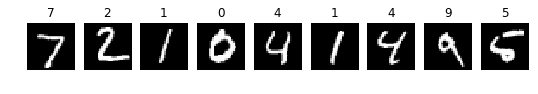

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [75]:
training_data, validation_data, test_data = load_data_shared()


# Run shallow architecture (single hidden layer) as baseline

In [17]:
mini_batch_size = 10

In [134]:
net = Network([
        FullyConnectedLayer(n_in=784, n_out=100),
        SoftmaxLayer(n_in=100, n_out=10)
    ], mini_batch_size)

In [128]:
net.SGD(training_data, 1, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 92.52%
This is the best validation accuracy to date.
The corresponding test accuracy is 91.96%
Finished training network.
Best validation accuracy of 92.52% obtained at iteration 4999
Corresponding test accuracy of 91.96%


In [150]:
# add a convolutional layer: 
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28),
                     filter_shape=(20, 1, 5, 5),
                     poolsize=(2, 2)),
        FullyConnectedLayer(n_in=20*12*12, n_out=100),
        SoftmaxLayer(n_in=100, n_out=10)], 
              mini_batch_size)

In [ ]:
net.SGD(training_data, 60, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 93.56%
This is the best validation accuracy to date.
The corresponding test accuracy is 92.74%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 96.03%
This is the best validation accuracy to date.
The corresponding test accuracy is 95.51%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 96.96%
This is the best validation accuracy to date.
The corresponding test accuracy is 96.57%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

In [ ]:
# remove fully connected layer: 
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28),
                     filter_shape=(20, 1, 5, 5), 
                     poolsize=(2, 2)),
        # FullyConnectedLayer(n_in=20*12*12, n_out=100),
        SoftmaxLayer(n_in=20*12*12, n_out=10)], 
              mini_batch_size)

In [ ]:
net.SGD(training_data, 60, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 94.05%
This is the best validation accuracy to date.
The corresponding test accuracy is 93.53%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 96.88%
This is the best validation accuracy to date.
The corresponding test accuracy is 96.58%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 97.62%
This is the best validation accuracy to date.
The corresponding test accuracy is 97.52%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

In [143]:
# add a second convolutional layer: 
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28),
                     filter_shape=(20, 1, 5, 5),
                     poolsize=(2, 2)),
        ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12),
                     filter_shape=(40, 20, 5, 5),
                     poolsize=(2, 2)),
        FullyConnectedLayer(n_in=40*4*4, n_out=100),
        SoftmaxLayer(n_in=100, n_out=10)
    ], mini_batch_size)

In [144]:
net.SGD(training_data, 60, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0


KeyboardInterrupt: ignored

In [145]:
# switch from sigmoid to tanh neurons: 
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28),
                     filter_shape=(20, 1, 5, 5),
                     poolsize=(2, 2),
                     activation_fn=tanh),
        ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12),
                     filter_shape=(40, 20, 5, 5),
                     poolsize=(2, 2),
                     activation_fn=tanh),
        FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=tanh),
        SoftmaxLayer(n_in=100, n_out=10)
    ], mini_batch_size)

In [149]:
net.SGD(training_data, 60, mini_batch_size, 0.1, validation_data, test_data)

KeyboardInterrupt: ignored

In [ ]:
# switch to ReLU neurons: 
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
                      filter_shape=(20, 1, 5, 5), 
                      poolsize=(2, 2), 
                      activation_fn=ReLU),
        ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12), 
                      filter_shape=(40, 20, 5, 5), 
                      poolsize=(2, 2), 
                      activation_fn=ReLU),
        FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
        SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [ ]:
# note the eta is an order of magnitude smaller, and lambda has been added as a parameter: 
net.SGD(training_data, 60, mini_batch_size, 0.03, 
            validation_data, test_data, lmbda=0.1)

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 97.54%
This is the best validation accuracy to date.
The corresponding test accuracy is 97.26%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 98.05%
This is the best validation accuracy to date.
The corresponding test accuracy is 98.00%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 98.29%
This is the best validation accuracy to date.
The corresponding test accuracy is 98.27%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

In [ ]:
expanded_training_data, _, _ = load_data_shared("../../neural-networks-and-deep-learning/data/mnist_expanded.pkl.gz")

In [147]:
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
                      filter_shape=(20, 1, 5, 5), 
                      poolsize=(2, 2), 
                      activation_fn=ReLU),
        ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12), 
                      filter_shape=(40, 20, 5, 5), 
                      poolsize=(2, 2), 
                      activation_fn=ReLU),
        FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
        SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [ ]:
net.SGD(expanded_training_data, 60, mini_batch_size, 0.03, 
            validation_data, test_data, lmbda=0.1)

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-batch number 19000
Training mini-batch number 20000
Training mini-batch number 21000
Training mini-batch number 22000
Training mini-batch number 23000
Training mini-batch number 24000
Epoch 0: validation accuracy 96.92%
This is the best validation accuracy to date.
The corresponding test accuracy is 97.05%
Training mini-batch number 25000
Training mini-batch number 2600

In [148]:
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28),
                     filter_shape=(20, 1, 5, 5),
                     poolsize=(2, 2),
                     activation_fn=ReLU),
        ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12),
                     filter_shape=(40, 20, 5, 5),
                     poolsize=(2, 2),
                     activation_fn=ReLU),
        FullyConnectedLayer(
            n_in=40*4*4, n_out=1000, activation_fn=ReLU, p_dropout=0.5),
        FullyConnectedLayer(
            n_in=1000, n_out=1000, activation_fn=ReLU, p_dropout=0.5),
        SoftmaxLayer(n_in=1000, n_out=10, p_dropout=0.5)],
        mini_batch_size)

In [ ]:
net.SGD(expanded_training_data, 40, mini_batch_size, 0.03, validation_data, test_data)

ERROR (theano.gof.opt): Optimization failure due to: local_fill_sink
ERROR (theano.gof.opt): node: Elemwise{add,no_inplace}(Rebroadcast{?,0}.0, Elemwise{second,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/ubuntu/miniconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 1772, in process_node
    replacements = lopt.transform(node)
  File "/home/ubuntu/miniconda2/lib/python2.7/site-packages/theano/tensor/opt.py", line 1621, in local_fill_sink
    c = node.op(*inputs)
  File "/home/ubuntu/miniconda2/lib/python2.7/site-packages/theano/gof/op.py", line 633, in __call__
    (i, ins, node))
ValueError: Cannot compute test value: input 0 (Rebroadcast{?,0}.0) of Op Elemwise{add,no_inplace}(Rebroadcast{?,0}.0, TensorConstant{(1, 1, 1, 1) of 0.0}) missing default value

ERROR (theano.gof.opt): Optimization failure due to: local_fill_sink
ERROR (theano.gof.opt): node: Elemwise{add,no_inplace}(Subtensor{::, ::, ::in

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-batch number 19000
Training mini-batch number 20000
Training mini-batch number 21000
Training mini-batch number 22000
Training mini-batch number 23000
Training mini-batch number 24000
Epoch 0: validation accuracy 98.63%
This is the best validation accuracy to date.
The corresponding test accuracy is 98.81%
Training mini-batch number 25000
Training mini-batch number 2600